# Hit clustering and segment classification with neural networks

In this notebook, I'll explore some ideas to use neural networks to associate hits into track clusters and/or classify hit pair segments with simple toy detector data.

In [1]:
# Select a GPU first
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '6'
cuda = True

In [2]:
# System imports
from __future__ import print_function

# Externals
import numpy as np
import matplotlib.pyplot as plt
from keras import layers, models
from keras import backend as K

%matplotlib notebook

Using TensorFlow backend.


## Data utilities

In [3]:
def gen_tracks(n, det_r):
    """
    Generate n straight tracks.
    
    Returns array of hit coordinates for each track with shape:
    (n, num_det_layers)
    """
    xin = np.random.uniform(size=n)
    xout = np.random.uniform(size=n)
    #slopes = (xout - xin) / (det_r.shape[0] - 1)
    slopes = (xout - xin) / (det_r[-1] - det_r[0])
    x = np.outer(slopes, det_r) + xin[:,None]
    return x

def transform_hits(x):
    """
    Sorts and transposes track hit coordinates.
    
    Given an array of hit positions with shape (num_track, num_layer),
    this function returns the hit positions per detector layer with shape
    (num_layer, num_track)
    """
    idx = np.argsort(x, axis=0)
    img = x[idx, np.arange(x.shape[1])]
    return img.T, idx.T

## Data visualization

Let's visualize an event in various ways. Draw the tracks and the association matrix.

In [4]:
# Detector config
det_r = np.array([0, 1, 2, 3, 4, 6, 8, 10, 12, 14], dtype=float)
num_det_layers = det_r.shape[0]

# Data config
num_tracks = 10

# Generate an example event
x = gen_tracks(num_tracks, det_r)
hits_x, hits_pid = transform_hits(x)
hits_r = np.zeros_like(hits_x)
hits_r[:] = det_r[:,None]

<IPython.core.display.Javascript object>


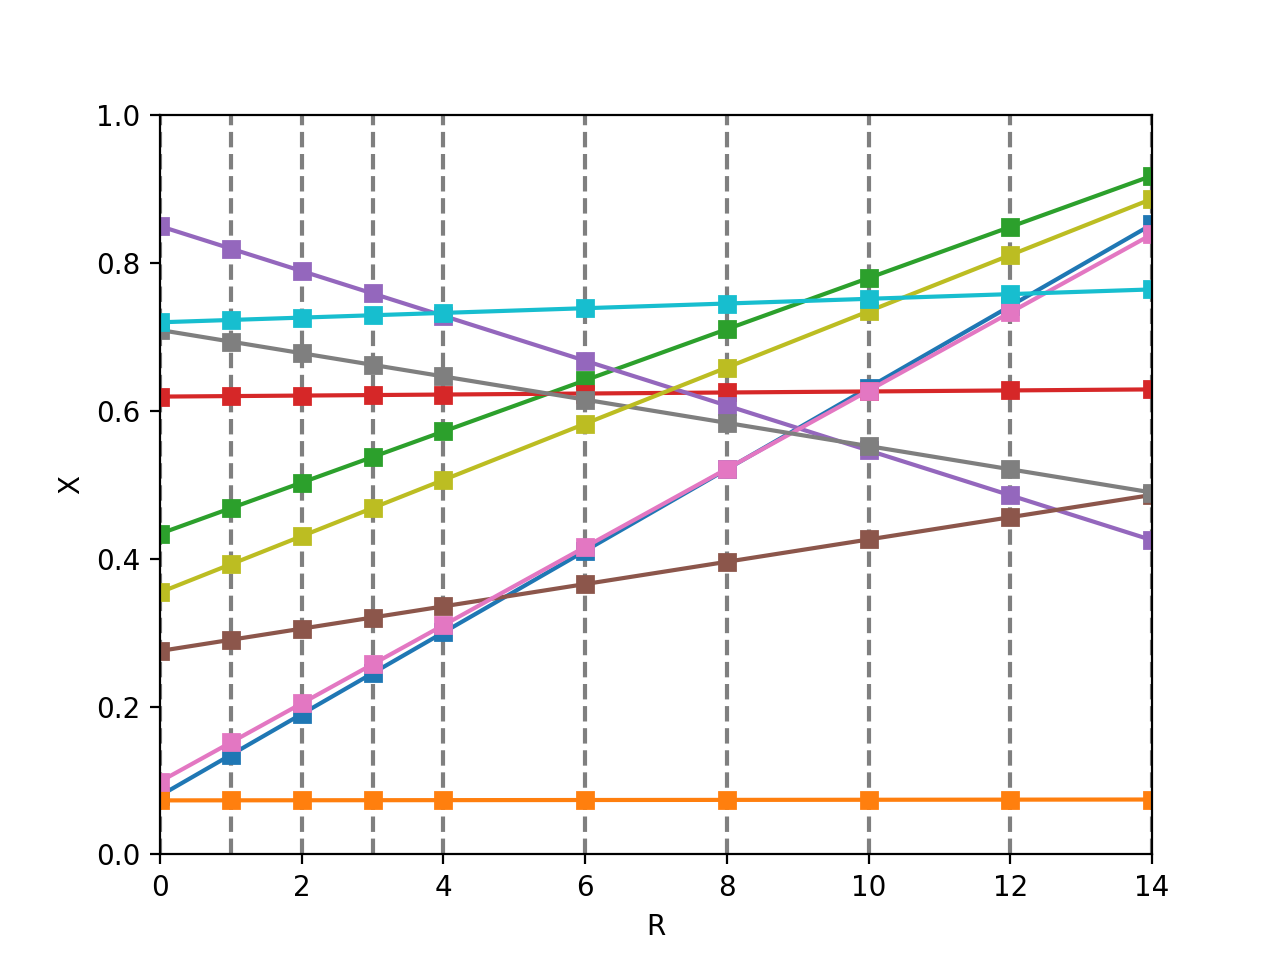

In [5]:
# Visualize the tracks
plt.figure()
for r in det_r:
    plt.plot([r, r], [0, 1], 'k--', alpha=0.5)
for i in range(x.shape[0]):
    plt.plot(det_r, x[i], 's-')
    plt.xlim((0, det_r[-1]))
    plt.ylim((0, 1))
    plt.xlabel('R')
    plt.ylabel('X')

In full hit clustering, there are $n(n-1)/2$ values to estimate, where $n$ is the number of hits. In the example of 5 tracks and 10 layers, there are thus 1225 values.

In segment classification, there are at most $n_i \times n_{i+1}$ values between each layer. In the 5 track example, then, there are 225 values.

<IPython.core.display.Javascript object>


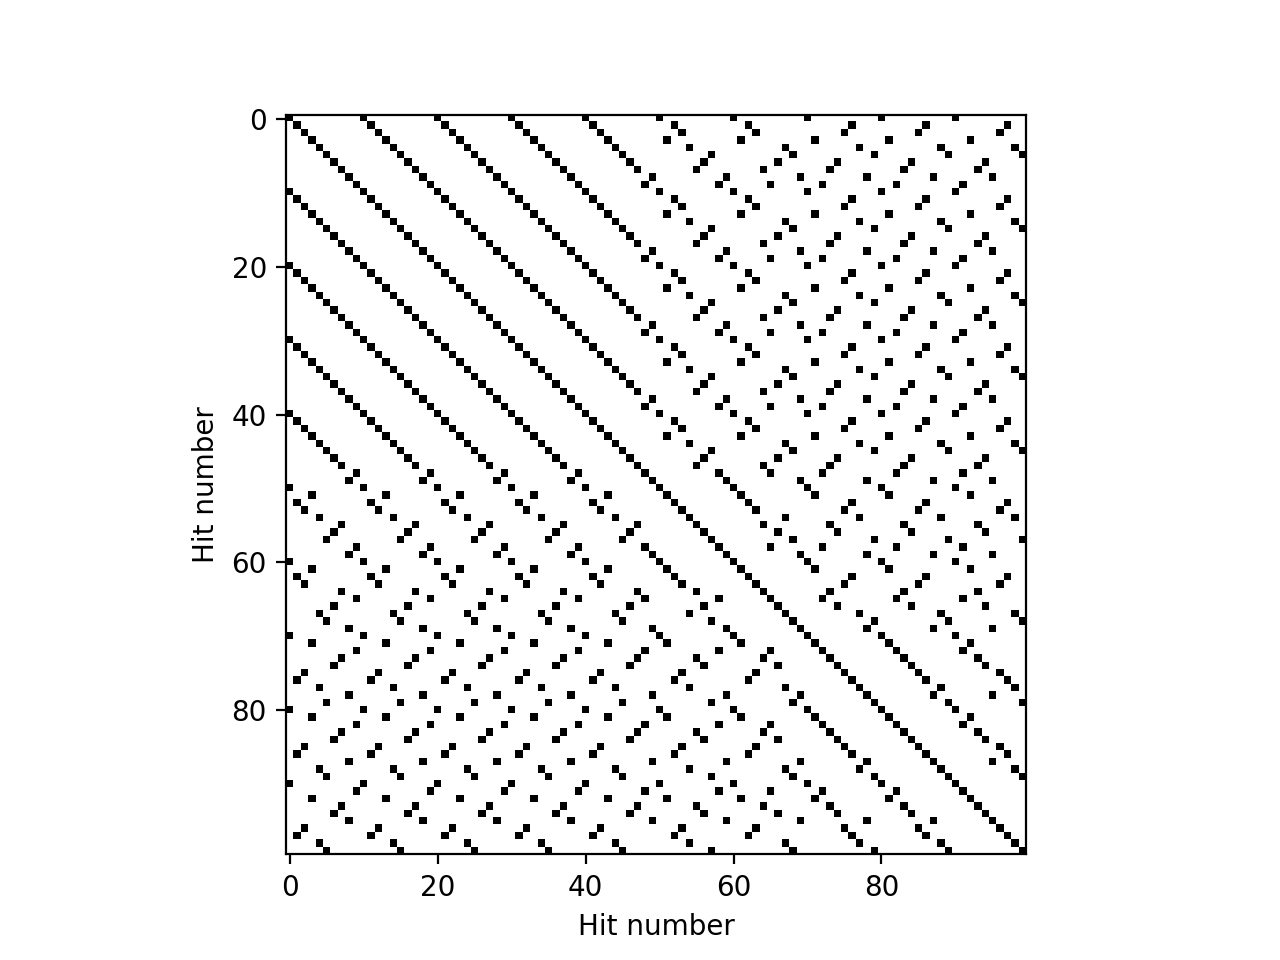

In [6]:
# Let's create the association matrix
flat_pid = hits_pid.flatten()
a = flat_pid[None,:] == flat_pid[:,None]

plt.figure()
plt.imshow(a, interpolation='none', cmap='gray_r')
plt.xlabel('Hit number')
plt.ylabel('Hit number')

Now let's think about how to formulate the reduced problem of segment classification. At each layer, I can consider all possible connections between the hits.

I could define an association matrix for each pair of detector layers. That's one way to visualize things.

In this simple case with ideal layers and no hit sharing, there are additional constraints. Each hit maps to only one hit on the next layer, which makes it a multi-class problem. However, in the real problem there may be missing hits (requiring a NULL class) and some hits will be shared.

In this simple case with ideal layers and no hit sharing, there are additional constraints. Each hit maps to only one hit on the next layer, which makes it a multi-class problem. However, in the real problem there may be missing hits (requiring a NULL class) and some hits will be shared.

<IPython.core.display.Javascript object>


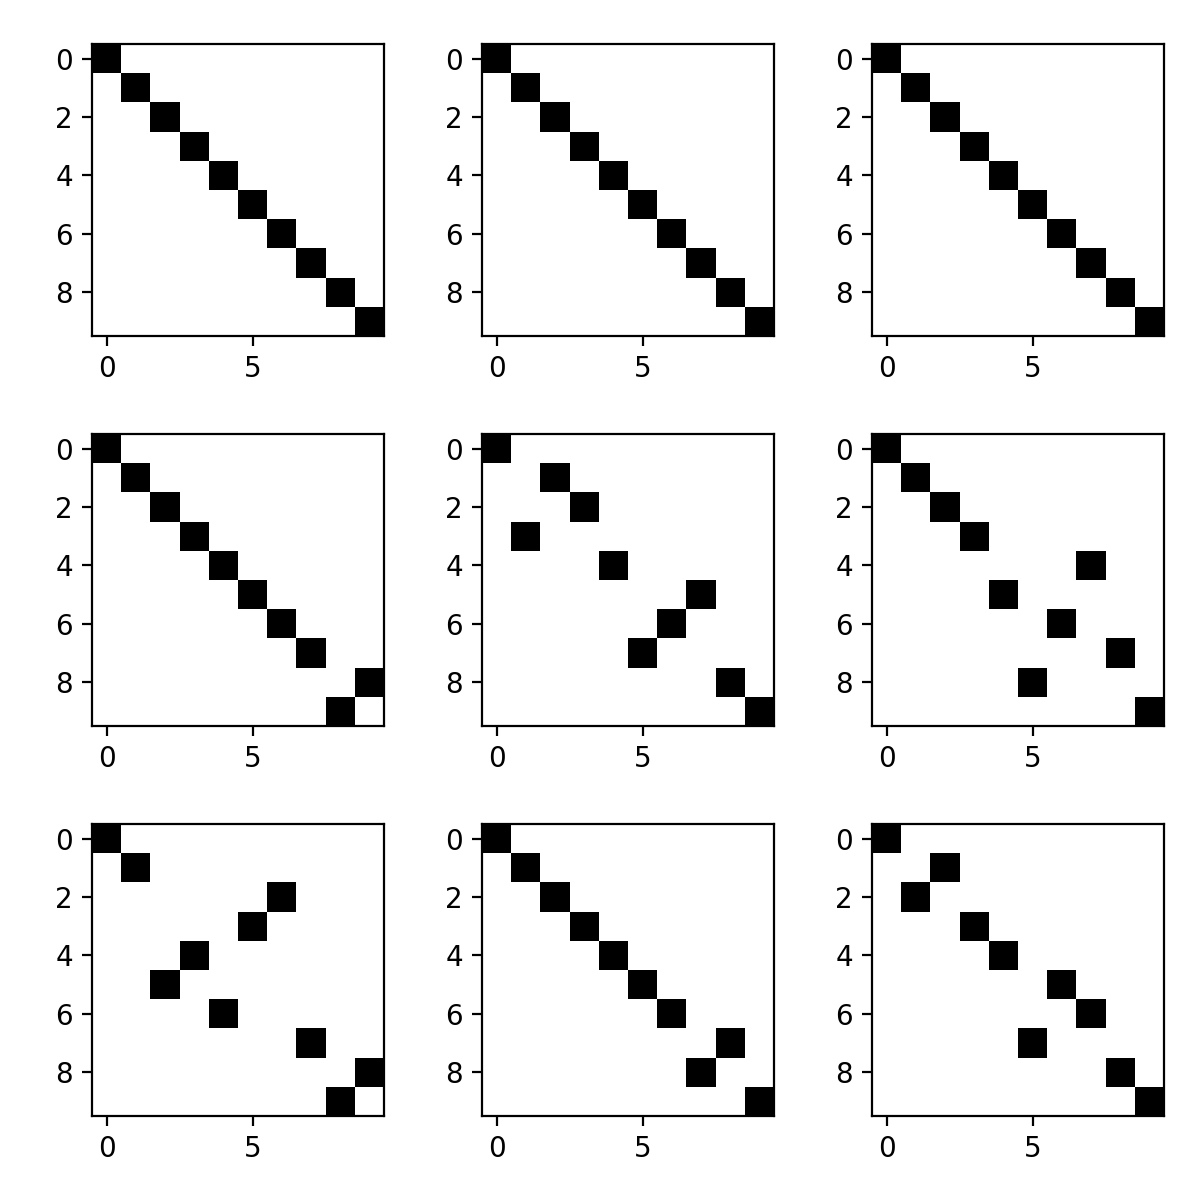

In [7]:
# True segment classification tensor
a = np.zeros((num_det_layers - 1, num_tracks, num_tracks))
for i in range(num_det_layers - 1):
    a[i] = hits_pid[i][:,None] == hits_pid[i+1][None,:]

ncols = 3
nrows = 3
plt.figure(figsize=(6,6))
for i in range(num_det_layers - 1):
    plt.subplot(nrows, ncols, i + 1)
    plt.imshow(a[i], interpolation='none', cmap='gray_r')
plt.tight_layout()

## Segment classifier model

Let's try to construct and train a simple model for predicting the classifications of segments.
I can use a fully-connected network, or I can probably share weights in a smart way to reduce the number of parameters in the model.

In [8]:
def build_fc_segmenter(hidden_dim=100, num_det_layers=num_det_layers, num_tracks=num_tracks):
    inputs = layers.Input((num_det_layers, num_tracks))
    hidden = layers.Flatten()(inputs)
    hidden = layers.Dense(hidden_dim, activation='relu')(hidden)
    hidden = layers.Dense(hidden_dim, activation='relu')(hidden)
    hidden = layers.Dense((num_det_layers - 1)*num_tracks*num_tracks)(hidden)
    hidden = layers.Reshape((-1, num_tracks))(hidden)
    outputs = layers.TimeDistributed(layers.Activation('softmax'))(hidden)
    # Compile the model
    model = models.Model(input=inputs, output=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='Nadam', metrics=['accuracy'])
    return model

In [9]:
# Data generator
def batch_generator(num_event):
    while True:
        # Create the data structures
        model_input = np.zeros((num_event, num_det_layers, num_tracks))
        model_target = np.zeros((num_event, (num_det_layers-1)*num_tracks, num_tracks))
        
        # Fill the data structures
        for ievt in xrange(num_event):
            hits_x, hits_pid = transform_hits(gen_tracks(num_tracks, det_r))
            model_input[ievt] = hits_x
            
            a = np.zeros((num_det_layers - 1, num_tracks, num_tracks))
            for jlay in xrange(num_det_layers - 1):
                a[jlay] = hits_pid[jlay][:,None] == hits_pid[jlay+1][None,:]
            model_target[ievt] = a.reshape((-1, num_tracks))
                
        yield model_input, model_target

In [10]:
# Model config
hidden_dim = 500

# Training config
batch_size = 64
epoch_size = 1024000
num_epoch = 10

In [ ]:
model1 = build_fc_segmenter(hidden_dim=hidden_dim)
model1.summary()

batcher = batch_generator(batch_size)
history1 = model1.fit_generator(batcher, samples_per_epoch=epoch_size,
                                nb_epoch=num_epoch)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 10, 10)        0                                            
____________________________________________________________________________________________________
flatten_1 (Flatten)              (None, 100)           0           input_1[0][0]                    
____________________________________________________________________________________________________
dense_1 (Dense)                  (None, 500)           50500       flatten_1[0][0]                  
____________________________________________________________________________________________________
dense_2 (Dense)                  (None, 500)           250500      dense_1[0][0]                    
___________________________________________________________________________________________

In [17]:
history1.history['acc']

[0.69053771371906625,
 0.75617412467300893,
 0.77899099620059131,
 0.79036921811848881,
 0.79760798716172576,
 0.80266136138886213,
 0.80647056296095254,
 0.8093861227780581,
 0.81190170427039265,
 0.81406998714804646]

In [18]:
# Create a little test set, just for visualization
test_input, test_target = batcher.next()
test_pred = model1.predict(test_input)

There are a couple of ways I can visualize the predictions. One is to simply draw the segment matrices as I've done above. A better way would be to draw the hits and the segments with a color scale to signify the classification.

Model targets


<IPython.core.display.Javascript object>


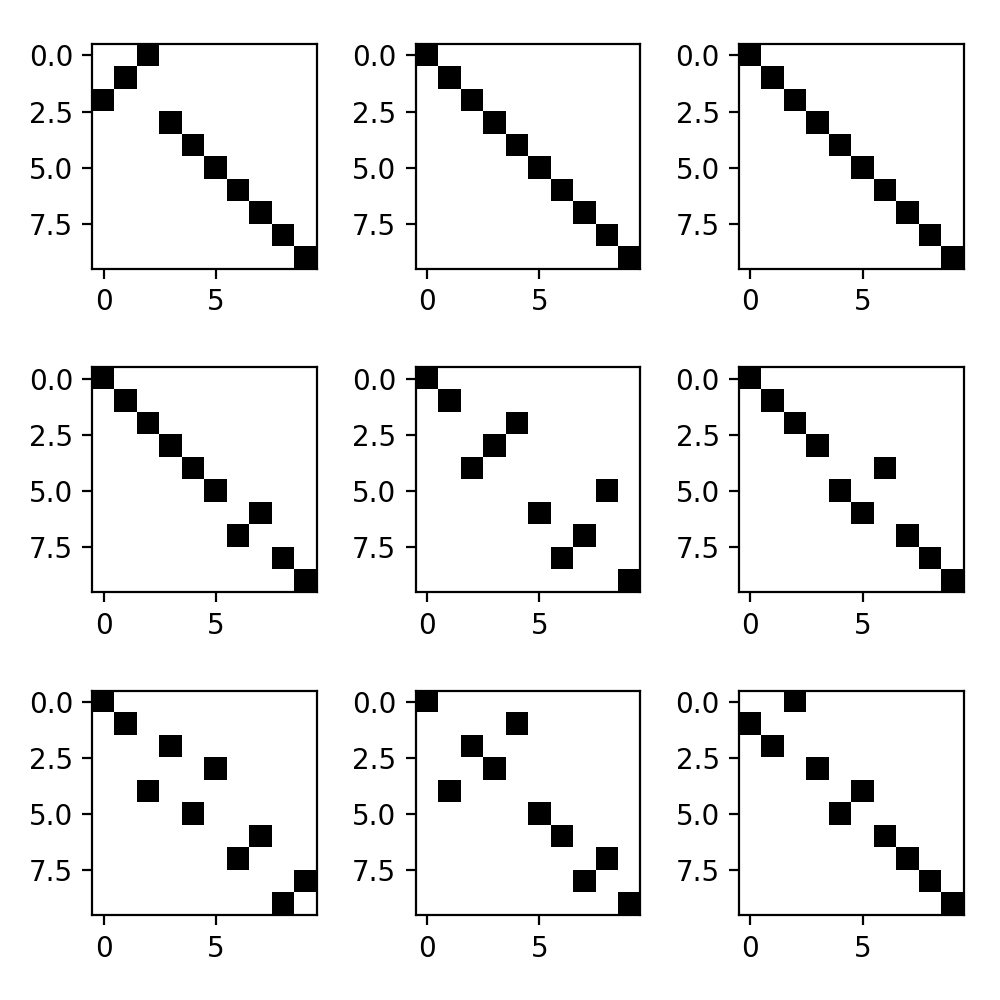

Model predictions


<IPython.core.display.Javascript object>


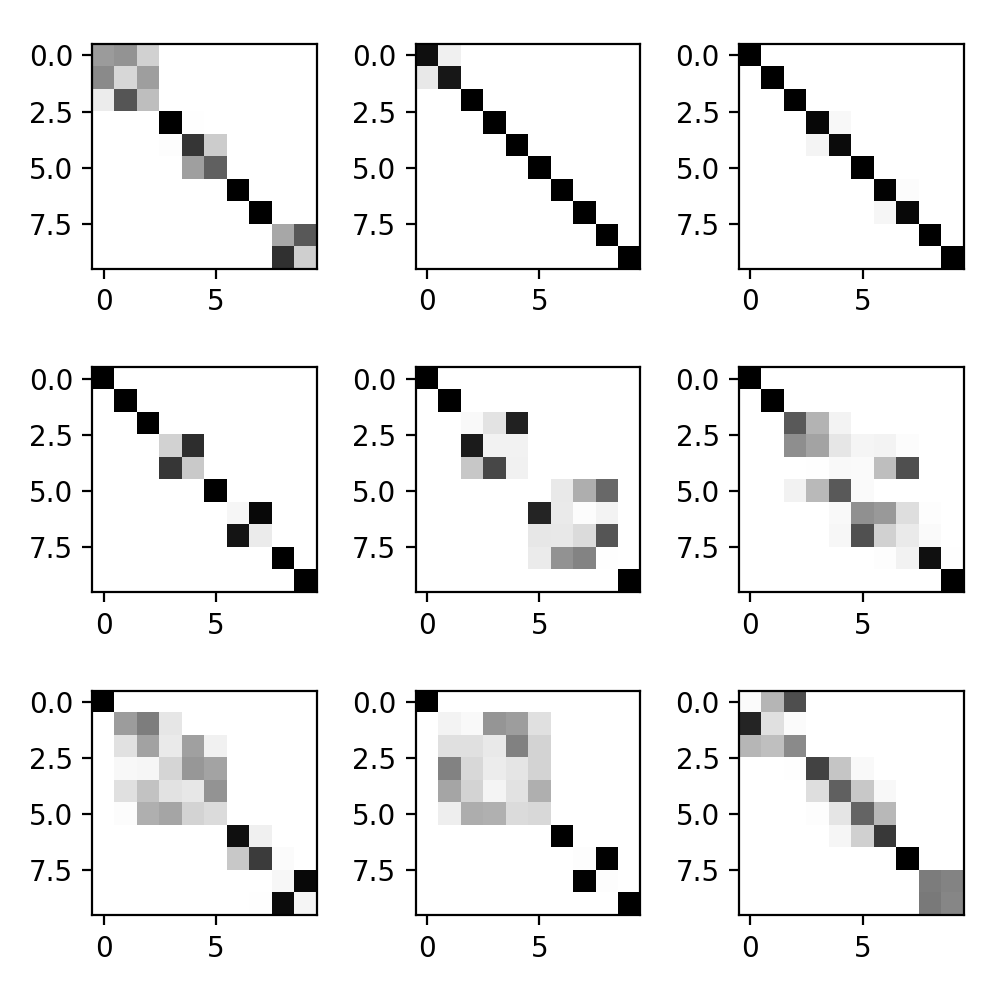

<IPython.core.display.Javascript object>


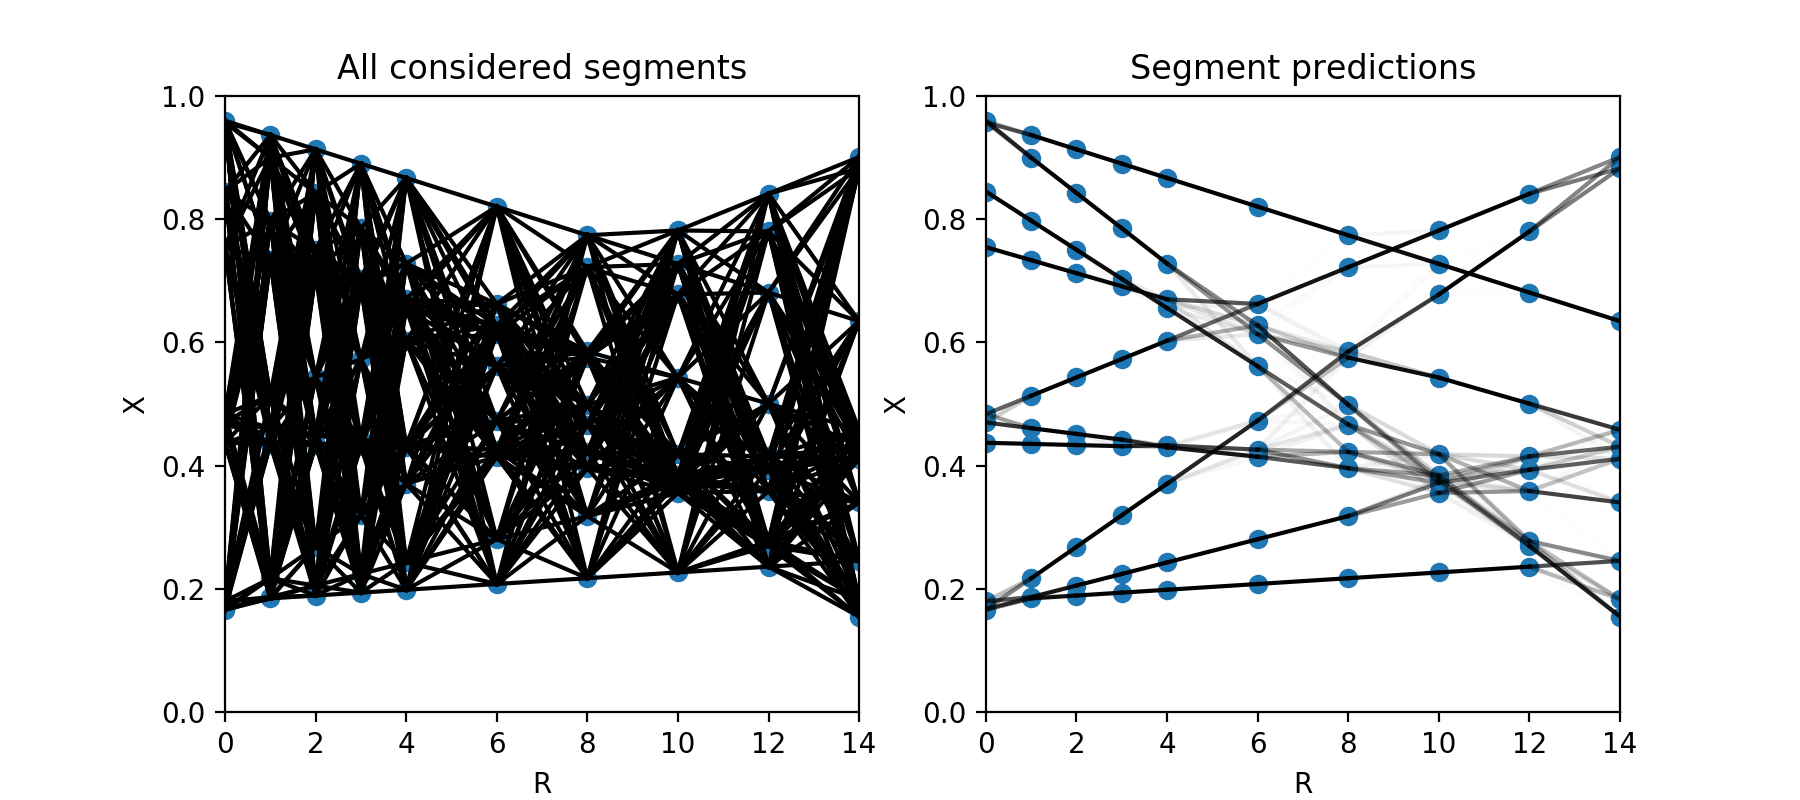

In [19]:
# Visualize the model segment scores
ievt = 0
target = test_target[ievt].reshape((num_det_layers-1, num_tracks, num_tracks))
pred = test_pred[ievt].reshape((num_det_layers-1, num_tracks, num_tracks))
hits = test_input[ievt]

ncols = 3
nrows = 3

# Draw the model target
print('Model targets')
plt.figure(figsize=(5,5))
for ilay in range(num_det_layers - 1):
    plt.subplot(nrows, ncols, ilay + 1)
    plt.imshow(target[ilay], interpolation='none', cmap='gray_r')
plt.tight_layout()

# Draw the model prediction
print('Model predictions')
plt.figure(figsize=(5,5))
for ilay in range(num_det_layers - 1):
    plt.subplot(nrows, ncols, ilay + 1)
    plt.imshow(pred[ilay], interpolation='none', cmap='gray_r')
plt.tight_layout()

# Visualize the model predictions in the hit space
plt.figure(figsize=(9,4))

# Draw all segments to illustrate the problem
plt.subplot(121)
# Draw the hits
plt.scatter(hits_r, hits)
plt.xlim((det_r[0], det_r[-1]))
plt.ylim((0, 1))
plt.xlabel('R')
plt.ylabel('X')
# Draw the segments
for i in range(pred.shape[0]):
    for j in range(pred.shape[1]):
        for k in range(pred.shape[2]):
            r = [det_r[i], det_r[i+1]]
            x = [hits[i, j], hits[i+1, k]]
            p = pred[i, j, k]
            plt.plot(r, x, 'k')
plt.title('All considered segments')

# Now draw segments according to their model prediction scores
plt.subplot(122)
# Draw the hits
plt.scatter(hits_r, hits)
plt.xlim((det_r[0], det_r[-1]))
plt.ylim((0, 1))
plt.xlabel('R')
plt.ylabel('X')
# Draw the segment scores
for i in range(pred.shape[0]):
    for j in range(pred.shape[1]):
        for k in range(pred.shape[2]):
            r = [det_r[i], det_r[i+1]]
            x = [hits[i, j], hits[i+1, k]]
            p = pred[i, j, k]
            plt.plot(r, x, 'k', alpha=p)
plt.title('Segment predictions');

## Smarter (?) segment classifier model

In this case, I'm going to try and learn localized transformations in a way that resembles convolutions. I want to calculate features for hit that take adjacent hits into account.

What I was thinking was to learn a transformation which takes one hit and all the hits on the adjacent layers and gets out a set of features for that hit. Then I want to define new transformations that work with these features. And so on. In the end, this can be transformed into a classification for each outgoing connection of a hit.

In [20]:
K.set_image_dim_ordering('tf')

In [21]:
# Data generator
def batch_generator(num_event, num_tracks, det_r):
    num_det_layers = det_r.shape[0]
    num_features = 2
    det_r_scaled = det_r / det_r.max()
    while True:
        # Create the data structures
        model_input = np.zeros((num_event, num_det_layers, num_tracks, num_features))
        model_target = np.zeros((num_event, (num_det_layers-1)*num_tracks, num_tracks))
        
        # Fill the data structures
        for ievt in xrange(num_event):
            hits_x, hits_pid = transform_hits(gen_tracks(num_tracks, det_r))
            model_input[ievt, :, :, 0] = hits_x
            model_input[ievt, :, :, 1] = det_r_scaled[:,None]
            
            a = np.zeros((num_det_layers - 1, num_tracks, num_tracks))
            for jlay in xrange(num_det_layers - 1):
                a[jlay] = hits_pid[jlay][:,None] == hits_pid[jlay+1][None,:]
            model_target[ievt] = a.reshape((-1, num_tracks))
                
        yield model_input, model_target

In [30]:
def stack_adjacent_features(x, num_det_layers, num_tracks, num_features):
    """Stacks each hit with the full set of hits on the previous and next layers"""
    # Flatten out the features axis
    flattened = K.reshape(x, (-1, num_det_layers, num_tracks*num_features))
    # Repeat the features along a new axis (will be the hit axis)
    repeated = K.repeat_elements(flattened[:,:,None], num_tracks, axis=2)
    # Pad with zeros for the upcoming slicing
    padded = K.spatial_2d_padding(repeated, (1, 0))
    # Slice out the backward and forward hit features
    bwd, fwd = padded[:,:-2], padded[:,2:]
    # Stack along the features axis
    return K.concatenate([bwd, x, fwd], axis=-1)

def build_conv_segmenter(num_det_layers, num_tracks,
                         adj_filters=[32]*4, lay_filters=[16]*2,
                         optimizer='Nadam'):
    num_features = 2
    inputs = layers.Input((num_det_layers, num_tracks, num_features))
    
    # Convolutions over adjacent layer features
    #num_filters = [32] * 4
    #num_conv_layers = len(num_filters)
    hidden = inputs
    stack_args = dict(num_det_layers=num_det_layers, num_tracks=num_tracks, num_features=num_features)
    conv_args = dict(nb_row=1, nb_col=1, border_mode='same', activation='relu')
    for i in range(len(adj_filters)):
        # Stack adjacent layer features
        stacked_hidden = layers.Lambda(stack_adjacent_features, arguments=stack_args)(hidden)
        # Apply convolution over the adjacent layer features
        hidden = layers.Conv2D(adj_filters[i], **conv_args)(stacked_hidden)
        stack_args['num_features'] = adj_filters[i]
    
    # Slice out the last layer since it has no outgoing segments
    hidden = layers.Lambda(lambda x: x[:,:-1])(hidden)
    
    # Convolutions over same-layer hit features
    conv_args = dict(nb_row=num_tracks, nb_col=1, border_mode='same', activation='relu')
    for i in range(len(lay_filters)):
        hidden = layers.Conv2D(lay_filters[i], **conv_args)(hidden)
        
    # Apply a final convolution without activation
    conv_args.pop('activation')
    hidden = layers.Conv2D(num_tracks, **conv_args)(hidden)
    # Apply softmax
    hidden = layers.Reshape((-1, num_tracks))(hidden)
    outputs = layers.TimeDistributed(layers.Activation('softmax'))(hidden)

    # Compile the model
    model = models.Model(input=inputs, output=outputs)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [56]:
# Detector config
#det_r = np.array([0, 1, 2, 3, 4, 6, 8, 10, 12, 14], dtype=np.float32)
#num_det_layers = det_r.shape[0]
# Data config
#num_tracks = 5

# Model config
adj_filters = [64] * 4
lay_filters = [32] * 2

# Training config
optimizer = 'Nadam'
batch_size = 64
epoch_size = 1024000
num_epoch = 10

In [44]:
model = build_conv_segmenter(num_det_layers, num_tracks,
                             adj_filters=adj_filters, lay_filters=lay_filters,
                             optimizer=optimizer)
model.summary()

batcher = batch_generator(batch_size, num_tracks, det_r)
history = model.fit_generator(batcher, samples_per_epoch=epoch_size,
                              nb_epoch=num_epoch)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_8 (InputLayer)             (None, 10, 10, 2)     0                                            
____________________________________________________________________________________________________
lambda_31 (Lambda)               (None, 10, 10, 42)    0           input_8[0][0]                    
____________________________________________________________________________________________________
convolution2d_52 (Convolution2D) (None, 10, 10, 64)    2752        lambda_31[0][0]                  
____________________________________________________________________________________________________
lambda_32 (Lambda)               (None, 10, 10, 1344)  0           convolution2d_52[0][0]           
___________________________________________________________________________________________

In [52]:
# Evaluate loss and accuracy on a test set
model.evaluate_generator(batcher, 102400)

[0.38696214545518159, 0.83748340886086226]

### Test set evaluation

In [53]:
# Create a little test set, just for visualization
test_input, test_target = batcher.next()
test_pred = model.predict(test_input)

<IPython.core.display.Javascript object>


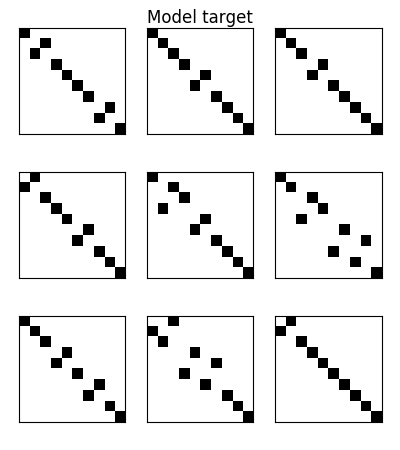

<IPython.core.display.Javascript object>


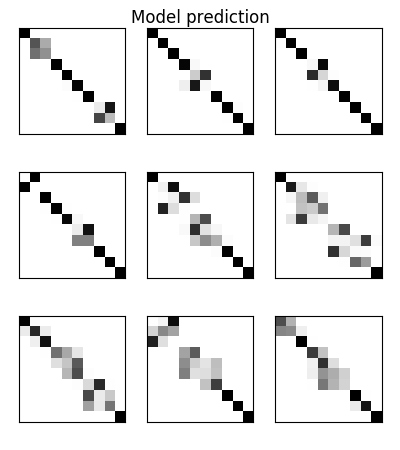

<IPython.core.display.Javascript object>


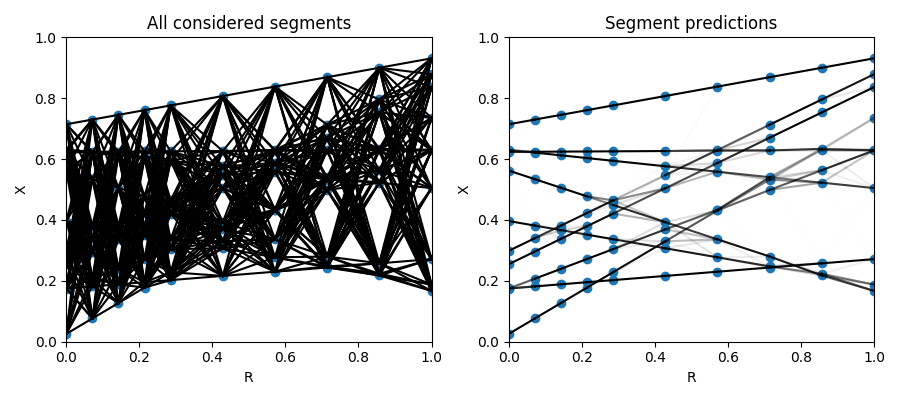

In [55]:
# Visualize the model segment scores
ievt = 1
target = test_target[ievt].reshape((num_det_layers-1, num_tracks, num_tracks))
pred = test_pred[ievt].reshape((num_det_layers-1, num_tracks, num_tracks))
hits_x = test_input[ievt, :, :, 0]
hits_r = test_input[ievt, :, :, 1]

ncols = 3
nrows = 3

# Draw the model target
plt.figure(figsize=(4,4.5)).suptitle('Model target')
for ilay in range(num_det_layers - 1):
    plt.subplot(nrows, ncols, ilay + 1)
    plt.imshow(target[ilay], interpolation='none', cmap='gray_r')
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()

# Draw the model prediction
plt.figure(figsize=(4, 4.5)).suptitle('Model prediction')
for ilay in range(num_det_layers - 1):
    plt.subplot(nrows, ncols, ilay + 1)
    plt.imshow(pred[ilay], interpolation='none', cmap='gray_r')
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()

# Visualize the model predictions in the hit space
plt.figure(figsize=(9, 4))

# Draw all segments to illustrate the problem
plt.subplot(121)
# Draw the hits
plt.scatter(hits_r, hits_x)
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.xlabel('R')
plt.ylabel('X')
# Draw the segments
for i in range(pred.shape[0]):
    for j in range(pred.shape[1]):
        for k in range(pred.shape[2]):
            #r = [det_r[i], det_r[i+1]]
            r = [hits_r[i, j], hits_r[i+1, k]]
            x = [hits_x[i, j], hits_x[i+1, k]]
            p = pred[i, j, k]
            plt.plot(r, x, 'k')
plt.title('All considered segments')

# Now draw segments according to their model prediction scores
plt.subplot(122)
# Draw the hits
plt.scatter(hits_r, hits_x)
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.xlabel('R')
plt.ylabel('X')
# Draw the segment scores
for i in range(pred.shape[0]):
    for j in range(pred.shape[1]):
        for k in range(pred.shape[2]):
            #r = [det_r[i], det_r[i+1]]
            r = [hits_r[i, j], hits_r[i+1, k]]
            x = [hits_x[i, j], hits_x[i+1, k]]
            p = pred[i, j, k]
            plt.plot(r, x, 'k', alpha=p)
plt.title('Segment predictions')
plt.tight_layout();